## Dynamic Model

## See 04_report.pdf for the requirement and verification section

In [1]:
import sympy as sym
import numpy as np
from scipy import linalg
import os

# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_drone

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_drone)

<module 'ae353_drone' from 'C:\\Users\\Randy666\\documents\\projects\\ae353\\ae353_controlSystem\\code_04\\ae353_drone.py'>

In [2]:
m = sym.nsimplify(0.5)
J1 = sym.nsimplify(0.0023)
J2 = sym.nsimplify(0.0023)
J3 = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

In [3]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# roll, pitch, yaw angles (radians)
phi, theta, psi = sym.symbols('phi, theta, psi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(0.5)
Jx = sym.nsimplify(0.0023)
Jy = sym.nsimplify(0.0023)
Jz = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

# rotation matrices
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Rxyz = Rx * Ry * Rz

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry * Rz).T * ex, Rz.T * ey, ez).inv(), full=True)

# applied forces
forces = sym.Matrix([[0], [0], [-m * g]]) + Rxyz * sym.Matrix([[0], [0], [f_z]])

# euler's equations
euler = sym.Matrix([[(1 / Jx) * (tau_x + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (tau_y + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (tau_z + (Jx - Jy) * w_x * w_y)]])

# equations of motion
f = sym.Matrix.vstack(sym.Matrix([[v_x], [v_y], [v_z]]),
                      M * sym.Matrix([[w_x], [w_y], [w_z]]),
                      (1 / m) * forces,
                      euler)
f = sym.simplify(f, full=True)

In [4]:
M

Matrix([
[ cos(psi)/cos(theta), -sin(psi)/cos(theta), 0],
[            sin(psi),             cos(psi), 0],
[-cos(psi)*tan(theta),  sin(psi)*tan(theta), 1]])

In [4]:
f

Matrix([
[                                                     v_x],
[                                                     v_y],
[                                                     v_z],
[                (w_x*cos(psi) - w_y*sin(psi))/cos(theta)],
[                             w_x*sin(psi) + w_y*cos(psi)],
[-w_x*cos(psi)*tan(theta) + w_y*sin(psi)*tan(theta) + w_z],
[                                        2*f_z*sin(theta)],
[                              -2*f_z*sin(phi)*cos(theta)],
[                     2*f_z*cos(phi)*cos(theta) - 981/100],
[                          10000*tau_x/23 - 17*w_y*w_z/23],
[                          10000*tau_y/23 + 17*w_x*w_z/23],
[                                               250*tau_z]])

## State-space model

In [5]:
p_x_e=0
p_y_e=0
p_z_e=0
phi_e = 0
theta_e = 0
psi_e = 0
v_x_e = 0
v_y_e = 0
v_z_e = 0
w_x_e = 0
w_y_e = 0
w_z_e = 0
tau_x_e = 0
tau_y_e = 0
tau_z_e = 0
f_z_e = 9.81/2
#equilibrium values

In [6]:
f_num = sym.lambdify((p_x,p_y,p_z,theta,phi,psi,
                 v_x,v_y,v_z,w_x,w_y,w_z,tau_x,
                 tau_y,tau_z,f_z),f)
F = f_num(p_x_e,p_y_e,p_z_e,theta_e,\
          phi_e,psi_e,v_x_e,v_y_e,v_z_e,
          w_x_e,w_y_e,w_z_e,tau_x_e,tau_y_e,\
          tau_z_e,f_z_e)
F
#verify that the above equilibrium values make f a null vector

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [7]:
A_num = sym.lambdify((p_x,p_y,p_z,theta,phi,psi,
                 v_x,v_y,v_z,w_x,w_y,w_z,tau_x,
                 tau_y,tau_z,f_z),f.jacobian([p_x,p_y,p_z,theta,phi,psi,
                 v_x,v_y,v_z,w_x,w_y,w_z]))
B_num = sym.lambdify((p_x,p_y,p_z,theta,phi,psi,
                 v_x,v_y,v_z,w_x,w_y,w_z,tau_x,
                 tau_y,tau_z,f_z),f.jacobian([tau_x,
                 tau_y,tau_z,f_z]))

In [8]:
A = A_num(p_x_e,p_y_e,p_z_e,theta_e,\
          phi_e,psi_e,v_x_e,v_y_e,v_z_e,
          w_x_e,w_y_e,w_z_e,tau_x_e,tau_y_e,\
          tau_z_e,f_z_e)
A = A.astype(float)
A

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         1.  , -0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  9.81,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -9.81,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  , -0.  

In [9]:
B = B_num(p_x_e,p_y_e,p_z_e,theta_e,\
          phi_e,psi_e,v_x_e,v_y_e,v_z_e,
          w_x_e,w_y_e,w_z_e,tau_x_e,tau_y_e,\
          tau_z_e,f_z_e)
B = B.astype(float)
B

array([[  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,  -0.       ],
       [  0.       ,   0.       ,   0.       ,   2.       ],
       [434.7826087,   0.       ,   0.       ,   0.       ],
       [  0.       , 434.7826087,   0.       ,   0.       ],
       [  0.       ,   0.       , 250.       ,   0.       ]])

In [10]:
#constructing the controllability matrix W
W = B   
for i in range(1, A.shape[0]):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])  #[B,AB,A^2@B,A^3@B.....]

print(np.linalg.matrix_rank(W)) #rank of W
print(A.shape[0]) #number of states in A

12
12


In [12]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A,B,Q,R)
    K = linalg.inv(R) @ B.T @ P
    return K

In [13]:
# Choose gains
Qc = np.diag([10,10,10,10,10,10,10,10,10,10,10,10])
Rc = np.diag([2,2,2,2])

# Find optimal gain matrix for controller
K = lqr(A, B, Qc, Rc)
K = K.astype(float)
# Find the closed-loop eigenvalues
print(f'Closed-loop eigenvalues of controller:\n {linalg.eigvals(A - B @ K)}')

Closed-loop eigenvalues of controller:
 [-972.20295423+0.j           -2.21471835+2.21472973j
   -2.21471835-2.21472973j -559.01609994+0.j
 -972.20295423+0.j           -2.21471835+2.21472973j
   -2.21471835-2.21472973j   -4.3525018 +0.j
   -1.0274863 +0.j           -1.0000016 +0.j
   -1.00000001+0.j           -1.00000001+0.j        ]


In [14]:
K

array([[ 2.23606798e+00,  8.71120817e-15, -2.96419029e-15,
         1.21733339e+01, -2.97504507e-14,  1.12032272e-15,
         3.24800266e+00,  1.79818144e-14, -2.55863235e-15,
         2.24855450e+00, -5.15820430e-17,  1.08952766e-15],
       [-3.85445371e-15, -2.23606798e+00, -4.10924474e-15,
         1.74422365e-15,  1.21733339e+01,  1.67125479e-15,
        -6.38706123e-15, -3.24800266e+00,  9.14239844e-16,
        -5.15820430e-17,  2.24855450e+00, -6.22775104e-16],
       [-2.87648648e-14,  3.29398315e-15,  2.61193338e-15,
        -4.24612455e-14, -1.03066087e-14,  2.23606798e+00,
        -1.52914488e-14,  3.57247665e-15,  4.72464734e-16,
         6.26478405e-16, -3.58095685e-16,  2.24006441e+00],
       [ 6.97993010e-17,  1.21836500e-15,  2.23606798e+00,
        -1.30496407e-14, -1.93301600e-15, -7.00034505e-16,
        -3.93798286e-15,  1.39499735e-15,  2.68999405e+00,
        -1.17697088e-17,  4.20550328e-18,  3.77971787e-18]])

In [15]:
g = sym.Matrix([[p_x-p_x_e],[p_y-p_y_e],[p_z-p_z_e],\
                [phi-phi_e],[theta-theta_e],[psi-psi_e]])
C_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z,\
                      w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), \
                     g.jacobian([p_x, p_y, p_z, phi, theta, psi, \
                                 v_x, v_y, v_z,  w_x, w_y, w_z]))
C = C_num(p_x_e, p_y_e, p_z_e, phi_e, theta_e, psi_e, v_x_e,
          v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e , 
          tau_z_e, f_z_e).astype(float)
C
C

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [16]:
g.shape

(6, 1)

In [17]:
C.shape

(6, 12)

In [18]:
#constructing the observability matrix O
O=C
for i in range(1,A.shape[0]):
    col = C@np.linalg.matrix_power(A,i)
    O = np.block([[O],[col]])
print(np.linalg.matrix_rank(O))
print(A.shape[0])


12
12


In [19]:
def LQR_obsv(A,C,R,Q):  #LQR for observer
    P = linalg.solve_continuous_are(A.T,C.T,np.linalg.inv(R), \
                  np.linalg.inv(Q)) #finding optimal cost matrix
    L = P@C.T@Q #injection matrix 
    return L

In [20]:
# injection matrix L
Q = np.diag([20,20,20,20,20,20]) 
R = np.diag([2,2,2,2,2,2,2,2,2,2,2,2])

# Find optimal gain matrix for controller
L = LQR_obsv(A,C,R,Q)
L = L.astype(float)

# Find the closed-loop eigenvalues
print(f'Closed-loop eigenvalues of controller:\n {linalg.eigvals(A - L @ C)}')

Closed-loop eigenvalues of controller:
 [-4.09300073+0.j         -2.131011  +1.84879596j -2.131011  -1.84879596j
 -4.09300073+0.j         -2.131011  +1.84879596j -2.131011  -1.84879596j
 -1.00051096+0.j         -1.00051096+0.j         -2.97875534+0.j
 -2.97875534+0.j         -1.06161041+0.j         -1.06161041+0.j        ]


In [21]:
L

array([[ 5.4361236 ,  0.        ,  0.        ,  0.95840375,  0.        ,
         0.        ],
       [ 0.        ,  5.4361236 ,  0.        ,  0.        , -0.95840375,
         0.        ],
       [ 0.        ,  0.        ,  4.04036574,  0.        ,  0.        ,
         0.        ],
       [ 0.95840375,  0.        ,  0.        ,  3.9194101 ,  0.        ,
         0.        ],
       [ 0.        , -0.95840375,  0.        ,  0.        ,  3.9194101 ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         4.04036574],
       [10.23498879,  0.        ,  0.        ,  8.59299363,  0.        ,
         0.        ],
       [ 0.        , 10.23498879,  0.        ,  0.        , -8.59299363,
         0.        ],
       [ 0.        ,  0.        ,  3.16227766,  0.        ,  0.        ,
         0.        ],
       [ 0.37338494,  0.        ,  0.        ,  3.14015663,  0.        ,
         0.        ],
       [ 0.        , -0.37338494,  0.        ,  0.

In [22]:
linalg.eigvals(A-L@C)

array([-4.09300073+0.j        , -2.131011  +1.84879596j,
       -2.131011  -1.84879596j, -4.09300073+0.j        ,
       -2.131011  +1.84879596j, -2.131011  -1.84879596j,
       -1.00051096+0.j        , -1.00051096+0.j        ,
       -2.97875534+0.j        , -2.97875534+0.j        ,
       -1.06161041+0.j        , -1.06161041+0.j        ])

## Version 1

In [23]:
simulator = ae353_drone.Simulator(display=False,seed=1)

In [24]:
class RobotController:
    def __init__(self,limiter=None):
        self.dt = 0.01
        self.limiter = limiter
        self.f_z_e =4.905
        self.tau_x_e = 0
        self.tau_y_e = 0
        self.tau_z_e = 0
        self.A = np.array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
             0.  ,  0.  ,  0.  ],
           [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
             0.  ,  0.  ,  0.  ],
           [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
             0.  ,  0.  ,  0.  ],
           [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
             1.  , -0.  ,  0.  ],
           [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
             0.  ,  1.  ,  0.  ],
           [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
            -0.  ,  0.  ,  1.  ],
           [ 0.  ,  0.  ,  0.  ,  9.81,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
             0.  ,  0.  ,  0.  ],
           [ 0.  ,  0.  ,  0.  ,  0.  , -9.81,  0.  ,  0.  ,  0.  ,  0.  ,
             0.  ,  0.  ,  0.  ],
           [ 0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
             0.  ,  0.  ,  0.  ],
           [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
             0.  , -0.  , -0.  ],
           [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
             0.  ,  0.  ,  0.  ],
           [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
             0.  ,  0.  ,  0.  ]])
        self.B = np.array([[  0.       ,   0.       ,   0.       ,   0.       ],
           [  0.       ,   0.       ,   0.       ,   0.       ],
           [  0.       ,   0.       ,   0.       ,   0.       ],
           [  0.       ,   0.       ,   0.       ,   0.       ],
           [  0.       ,   0.       ,   0.       ,   0.       ],
           [  0.       ,   0.       ,   0.       ,   0.       ],
           [  0.       ,   0.       ,   0.       ,   0.       ],
           [  0.       ,   0.       ,   0.       ,  -0.       ],
           [  0.       ,   0.       ,   0.       ,   2.       ],
           [434.7826087,   0.       ,   0.       ,   0.       ],
           [  0.       , 434.7826087,   0.       ,   0.       ],
           [  0.       ,   0.       , 250.       ,   0.       ]])
        self.C = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])
        self.K = np.array([[ 2.23606798e+00,  8.71120817e-15, -2.96419029e-15,
                 1.21733339e+01, -2.97504507e-14,  1.12032272e-15,
                 3.24800266e+00,  1.79818144e-14, -2.55863235e-15,
                 2.24855450e+00, -5.15820430e-17,  1.08952766e-15],
               [-3.85445371e-15, -2.23606798e+00, -4.10924474e-15,
                 1.74422365e-15,  1.21733339e+01,  1.67125479e-15,
                -6.38706123e-15, -3.24800266e+00,  9.14239844e-16,
                -5.15820430e-17,  2.24855450e+00, -6.22775104e-16],
               [-2.87648648e-14,  3.29398315e-15,  2.61193338e-15,
                -4.24612455e-14, -1.03066087e-14,  2.23606798e+00,
                -1.52914488e-14,  3.57247665e-15,  4.72464734e-16,
                 6.26478405e-16, -3.58095685e-16,  2.24006441e+00],
               [ 6.97993010e-17,  1.21836500e-15,  2.23606798e+00,
                -1.30496407e-14, -1.93301600e-15, -7.00034505e-16,
                -3.93798286e-15,  1.39499735e-15,  2.68999405e+00,
                -1.17697088e-17,  4.20550328e-18,  3.77971787e-18]])
        
        self.L = np.array([[ 5.4361236 ,  0.        ,  0.        ,  0.95840375,  0.        ,
                 0.        ],
               [ 0.        ,  5.4361236 ,  0.        ,  0.        , -0.95840375,
                 0.        ],
               [ 0.        ,  0.        ,  4.04036574,  0.        ,  0.        ,
                 0.        ],
               [ 0.95840375,  0.        ,  0.        ,  3.9194101 ,  0.        ,
                 0.        ],
               [ 0.        , -0.95840375,  0.        ,  0.        ,  3.9194101 ,
                 0.        ],
               [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                 4.04036574],
               [10.23498879,  0.        ,  0.        ,  8.59299363,  0.        ,
                 0.        ],
               [ 0.        , 10.23498879,  0.        ,  0.        , -8.59299363,
                 0.        ],
               [ 0.        ,  0.        ,  3.16227766,  0.        ,  0.        ,
                 0.        ],
               [ 0.37338494,  0.        ,  0.        ,  3.14015663,  0.        ,
                 0.        ],
               [ 0.        , -0.37338494,  0.        ,  0.        ,  3.14015663,
                 0.        ],
               [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                 3.16227766]])
    def get_color(self):
        return [0., 1., 0.]

    def reset(self, pos):
        # Initialize the state estimate
        self.xhat = np.zeros((12,1))
        
    def run(self, pos, rpy, pos_ring, is_last_ring, pos_others):
        p_est = np.array([self.xhat[0],self.xhat[1],self.xhat[2]])
        p_est = p_est.T[0]
        
        p_x_est = p_est[0]
        p_y_est = p_est[1]
        p_z_est = p_est[2]
        
        p_x_des =pos_ring[0]
        p_y_des =pos_ring[1]
        p_z_des =pos_ring[2]
        
        err = pos_ring - p_est
        
        if (np.abs(err[1])>0.5):
            p_x_des = p_x_est + (3*(err[0])/(np.linalg.norm(err)))
            p_y_des = p_y_est + (3*(err[1])/(np.linalg.norm(err)))
            p_z_des = p_z_est + (6*(err[2])/(np.linalg.norm(err)))
        
        else:
            p_x_des = p_x_est + (1*(err[0])/(np.abs(err[0])))
            p_y_des = p_y_est + (1*(err[1])/(np.abs(err[1])))
            p_z_des = p_z_est + (3*(err[2])/(np.abs(err[2])))
            #note: this part is referenced from `tylerbr2`
       
        
        x_des = np.array([[p_x_des-0],[p_y_des-0],[p_z_des-0],\
                          [0],[0],[0],[0],[0],\
                          [0],[0],[0],[0]])

        u = -self.K @ (self.xhat - x_des)
        tau_x = u[0,0]+self.tau_x_e
        tau_y = u[1,0]+self.tau_y_e
        tau_z = u[2,0]+self.tau_z_e
        f_z   = u[3,0]+self.f_z_e
        y = np.block([pos,rpy]).reshape(6,1).astype(float)
        #this part references `tylerbr2`
        self.xhat = self.xhat+ self.dt * ((self.A @ self.xhat) + (self.B @ u) - (self.L @ (self.C @ self.xhat - y)))
        
        if self.limiter is not None:
            tau_x,tau_y,tau_z,f_z = self.limiter(tau_x,tau_y,tau_z,f_z)
                                                 
        if (is_last_ring == True and (np.linalg.norm(err)<3)):
            return 0,0,0,0
        # this part references `rpate392`
       
        return tau_x, tau_y, tau_z, f_z

In [25]:
simulator.clear_drones()

In [26]:
simulator.add_drone(RobotController, 'jushanc', 'terminator.png')

In [27]:
simulator.reset()

In [28]:
simulator.run(max_time=10)


error on run of drone jushanc (turning it off):
Traceback (most recent call last):
  File "C:\Users\Gover\documents\projects\ae353\code_04\ae353_drone.py", line 518, in step
    np.delete(all_pos, index, axis=0))
  File "<ipython-input-24-73d195c6678e>", line 139, in run
    tau_x,tau_y,tau_z,f_z = self.limiter(tau_x,tau_y,tau_z,f_z)
  File "C:\Users\Gover\documents\projects\ae353\code_04\ae353_drone.py", line 393, in enforce_motor_limits
    u = linalg.solve(self.M, s)
  File "C:\Users\Gover\Anaconda3\lib\site-packages\scipy\linalg\basic.py", line 140, in solve
    b1 = atleast_1d(_asarray_validated(b, check_finite=check_finite))
  File "C:\Users\Gover\Anaconda3\lib\site-packages\scipy\_lib\_util.py", line 246, in _asarray_validated
    a = toarray(a)
  File "C:\Users\Gover\Anaconda3\lib\site-packages\numpy\lib\function_base.py", line 499, in asarray_chkfinite
    "array must not contain infs or NaNs")
ValueError: array must not contain infs or NaNs



C:\Users\Gover\documents\projects\ae353\code_04\ae353_drone.py:391: RuntimeWarning: overflow encountered in matmul
  s = np.clip(self.M @ u, self.s_min, self.s_max)
C:\Users\Gover\Anaconda3\lib\site-packages\ipykernel_launcher.py:136: RuntimeWarning: overflow encountered in matmul
C:\Users\Gover\Anaconda3\lib\site-packages\ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in matmul
C:\Users\Gover\documents\projects\ae353\code_04\ae353_drone.py:391: RuntimeWarning: invalid value encountered in matmul
  s = np.clip(self.M @ u, self.s_min, self.s_max)


This is the first version of my observer-controller system. It is obvious that controller-observer has failed becaufse `inf` values in arrays are encountered. Thus, the drone is not able to run at all. One hypothesis for why it has failed is we have inappropriate weight matrices chosen while obtaining an optimized gain matrix from the LQR method. In particular, the gain matrix K and injection matrix L returned by the LQR method according to our choice of weight matrices make the drone overshoot way so much that the pybullet environment is broken. 

In [29]:
simulator.disconnect()

## Version2

In [30]:
# Choose gains
Qc = np.diag([15,25,20,1,1,1,1,1,1,1,1,1]) #this part references `rpate392`
Rc = 25*np.eye(4)

#note : this is referneced from `tylerbr2`

# Find optimal gain matrix for controller
K = lqr(A, B, Qc, Rc)
K

array([[ 7.74596669e-01, -4.67470221e-16, -4.31580549e-16,
         1.49592403e+00, -3.15856267e-15,  1.81444756e-16,
         5.25581620e-01,  1.17183345e-15, -6.30045710e-16,
         2.16520785e-01, -2.93516297e-17,  7.49427840e-18],
       [-1.31833459e-15, -1.00000000e+00, -6.39109626e-17,
        -1.88332103e-15,  1.60790981e+00,  1.78160395e-16,
        -7.36828113e-16, -6.06473709e-01,  1.44625139e-15,
        -2.93516297e-17,  2.17707109e-01,  4.72334254e-17],
       [ 5.88348433e-16, -7.21879151e-16, -2.06716638e-15,
        -1.81478201e-17,  6.92156983e-16,  2.00000000e-01,
         1.92764708e-17, -3.73813741e-16, -1.49515507e-15,
         4.30921008e-18,  2.71592196e-17,  2.03960781e-01],
       [-1.32846367e-16, -4.44882671e-16,  8.94427191e-01,
        -1.23308428e-17,  2.57549888e-16,  2.91766667e-17,
         7.35795043e-18, -1.18552206e-16,  9.66657742e-01,
        -2.89821026e-18,  6.65275638e-18, -1.19612406e-17]])

In [31]:
R = np.eye(12)
Q = 500*np.eye(6)
#note: this part is referenced from `tylerbr2`
#Find optimal gain matrix for controller
L = LQR_obsv(A,C,R,Q)
L

array([[ 2.34263077e+01,  0.00000000e+00,  0.00000000e+00,
         2.09756561e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.34263077e+01,  0.00000000e+00,
         0.00000000e+00, -2.09756561e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.33392665e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.09756561e-01,  0.00000000e+00,  0.00000000e+00,
         2.33383238e+01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.09756561e-01,  0.00000000e+00,
         0.00000000e+00,  2.33383238e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.33392665e+01],
       [ 2.44179444e+01,  0.00000000e+00,  0.00000000e+00,
         9.80036579e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.44179444e+01,  0.00000000e+00,
         0.00000000e+00, -9.80036579e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.236

In [32]:
class Controller_Version2(RobotController):
    def __init__(self, limiter=None):
        super().__init__(limiter)
        self.K = np.array([[ 7.74596669e-01, -4.67470221e-16, -4.31580549e-16,
         1.49592403e+00, -3.15856267e-15,  1.81444756e-16,
         5.25581620e-01,  1.17183345e-15, -6.30045710e-16,
         2.16520785e-01, -2.93516297e-17,  7.49427840e-18],
       [-1.31833459e-15, -1.00000000e+00, -6.39109626e-17,
        -1.88332103e-15,  1.60790981e+00,  1.78160395e-16,
        -7.36828113e-16, -6.06473709e-01,  1.44625139e-15,
        -2.93516297e-17,  2.17707109e-01,  4.72334254e-17],
       [ 5.88348433e-16, -7.21879151e-16, -2.06716638e-15,
        -1.81478201e-17,  6.92156983e-16,  2.00000000e-01,
         1.92764708e-17, -3.73813741e-16, -1.49515507e-15,
         4.30921008e-18,  2.71592196e-17,  2.03960781e-01],
       [-1.32846367e-16, -4.44882671e-16,  8.94427191e-01,
        -1.23308428e-17,  2.57549888e-16,  2.91766667e-17,
         7.35795043e-18, -1.18552206e-16,  9.66657742e-01,
        -2.89821026e-18,  6.65275638e-18, -1.19612406e-17]])
        self.L = np.array([[ 2.34263077e+01,  0.00000000e+00,  0.00000000e+00,
         2.09756561e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.34263077e+01,  0.00000000e+00,
         0.00000000e+00, -2.09756561e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.33392665e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.09756561e-01,  0.00000000e+00,  0.00000000e+00,
         2.33383238e+01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.09756561e-01,  0.00000000e+00,
         0.00000000e+00,  2.33383238e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.33392665e+01],
       [ 2.44179444e+01,  0.00000000e+00,  0.00000000e+00,
         9.80036579e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.44179444e+01,  0.00000000e+00,
         0.00000000e+00, -9.80036579e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.23606798e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.82250737e-03,  0.00000000e+00,  0.00000000e+00,
         2.23606780e+01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.82250737e-03,  0.00000000e+00,
         0.00000000e+00,  2.23606780e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.23606798e+01]])

In [33]:
simulator = ae353_drone.Simulator(display=True,seed=2)

In [34]:
simulator.clear_drones()

In [35]:
simulator.add_drone(Controller_Version2, 'jushanc', 'terminator.png')

In [36]:
simulator.reset()

In [37]:
simulator.run(max_time=15.0)

error: GetBasePositionAndOrientation failed.

In [38]:
drone_name = 'jushanc'
drone = simulator.get_drone_by_name(drone_name)

if drone is None:
    drone_names = '\n'.join([d['name'] for d in simulator.drones])
    msg = f'The simulator has no drone with name "{drone_name}".'
    if len(drone_names) == 0:
        msg += f' The simulator has no drones at all, in fact.'
    else:
        msg += f' The simulator has these drones:'
        msg += f'\n==========\n{drone_names}\n==========\n'
    print(msg)


In [39]:
data = drone['data'].copy()
for key in data.keys():
    data[key] = np.array(data[key]).T

In [40]:
if drone['finish_time'] is None:
    if drone['running']:
        print(f'The drone "{drone["name"]}" did not finish.')
    else:
        print(f'The drone "{drone["name"]}" did not finish and was no longer running.')
else:
    print(f'The drone "{drone["name"]}" finished with time: {drone["finish_time"]}')

The drone "jushanc" did not finish.


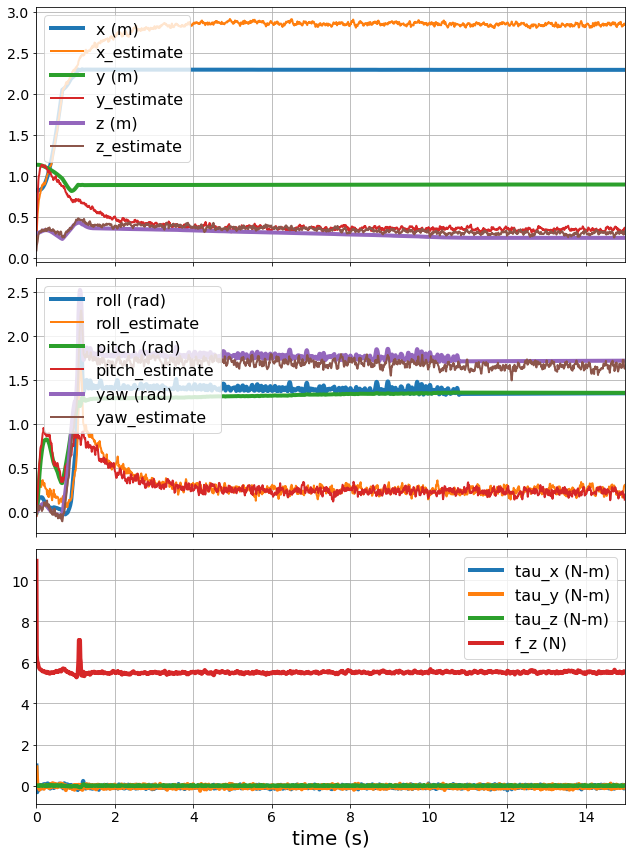

In [41]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_rpy, ax_act) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['pos'][0, :], label='x (m)', linewidth=4)
ax_pos.plot(data['t'],data['xhat'][0,:],label='x_estimate',linewidth=2)
ax_pos.plot(data['t'], data['pos'][1, :], label='y (m)', linewidth=4)
ax_pos.plot(data['t'],data['xhat'][1,:],label='y_estimate',linewidth=2)
ax_pos.plot(data['t'], data['pos'][2, :], label='z (m)', linewidth=4)
ax_pos.plot(data['t'],data['xhat'][2,:],label='z_estimate',linewidth=2)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Roll, pitch, and yaw angles
ax_rpy.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['xhat'][3, :], label='roll_estimate', linewidth=2)
ax_rpy.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['xhat'][4, :], label='pitch_estimate', linewidth=2)
ax_rpy.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['xhat'][5, :], label='yaw_estimate', linewidth=2)
ax_rpy.grid()
ax_rpy.legend(fontsize=16)
ax_rpy.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'].flatten(), label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'].flatten(), label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'].flatten(), label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'].flatten(), label='f_z (N)', linewidth=4)
ax_act.grid()
ax_act.legend(fontsize=16)
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

 In version 2, the weight matrices for K and L been refined. We can observe in the simulation that the drone no longer overshoots abruptly. However, the drone does not fly through the rings as expected. Thus, we will modify how the drone changes it desired positions based on the errors captured by the sensor.

## Version 3

In [42]:
simulator.disconnect()

In [16]:
def LQR(A,B,Q,R):
    P = linalg.solve_continuous_are(A,B,Q,R)
    K = linalg.inv(R) @ B.T @ P
    
    return K

In [17]:
QC = np.diag((10,25,20,1,1,1,5,1,5,1,1,1)) 
RC = np.diag((23,23,23,23))
K = LQR(A, B, QC, RC)
K# this part references `raa5`

array([[ 6.59380473e-01,  1.60534092e-14, -1.07465565e-15,
         1.73195859e+00, -1.23883249e-14,  1.57849817e-16,
         6.70983580e-01,  8.58517395e-15, -1.28861957e-15,
         2.26815499e-01, -1.00116757e-16,  2.46410746e-17],
       [ 3.95983053e-15, -1.04257207e+00, -1.74343352e-15,
        -8.79470106e-15,  1.67354335e+00,  6.12226404e-16,
        -2.59611690e-15, -6.31818634e-01, -3.49256295e-16,
        -1.00116757e-16,  2.26222369e-01, -8.89770196e-17],
       [ 1.27081967e-15,  5.35804445e-16,  5.67172187e-16,
         1.25368799e-16,  5.39937850e-17,  2.08514414e-01,
         1.66545657e-16,  8.77687954e-17,  1.86208208e-15,
         1.41686179e-17, -5.11617863e-17,  2.12476766e-01],
       [ 1.94796628e-17, -1.96781109e-16,  9.32504808e-01,
        -1.71969650e-16,  2.83326749e-17,  2.67847575e-16,
        -4.33296394e-19,  4.11742867e-18,  1.07233209e+00,
        -5.92765004e-18, -1.60657896e-18,  1.48966566e-17]])

In [18]:
QO = np.diag((700,700,700,600,600,600))
RO = np.diag((1,1,1,1,1,1,1,1,1,1,1,1))
#note: this part is referenced from `tylerbr2`
#Find optimal gain matrix for controller
L = LQR_obsv(A,C,RO,QO)
L

array([[ 2.75129226e+01,  0.00000000e+00,  0.00000000e+00,
         1.85098263e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.75129226e+01,  0.00000000e+00,
         0.00000000e+00, -1.85098263e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.74392971e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.15947973e-01,  0.00000000e+00,  0.00000000e+00,
         2.54744934e+01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.15947973e-01,  0.00000000e+00,
         0.00000000e+00,  2.54744934e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.54752781e+01],
       [ 2.85004418e+01,  0.00000000e+00,  0.00000000e+00,
         9.79490615e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.85004418e+01,  0.00000000e+00,
         0.00000000e+00, -9.79490615e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.645

In [19]:
class RobotController:
    #this part references `raa5`
    
    def __init__(self, limiter=None):
        self.dt = 0.01
        self.limiter = limiter
        self.p_x_e = p_x_e
        self.p_y_e = p_y_e
        self.p_z_e = p_z_e
        self.phi_e = phi_e
        self.theta_e = theta_e
        self.psi_e = psi_e
        self.v_x_e = v_x_e
        self.v_y_e = v_y_e
        self.v_z_e = v_z_e
        self.w_x_e = w_x_e
        self.w_y_e = w_y_e
        self.w_z_e = w_z_e
        self.tau_x_e = tau_x_e
        self.tau_y_e = tau_y_e
        self.tau_z_e = tau_z_e
        self.f_z_e = f_z_e
        self.A = np.array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         1.  , -0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  9.81,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -9.81,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  , -0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ]])
        self.B = np.array([[  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,  -0.       ],
       [  0.       ,   0.       ,   0.       ,   2.       ],
       [434.7826087,   0.       ,   0.       ,   0.       ],
       [  0.       , 434.7826087,   0.       ,   0.       ],
       [  0.       ,   0.       , 250.       ,   0.       ]])
        self.C = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
        self.K = np.array([[ 6.59380473e-01,  1.60534092e-14, -1.07465565e-15,
         1.73195859e+00, -1.23883249e-14,  1.57849817e-16,
         6.70983580e-01,  8.58517395e-15, -1.28861957e-15,
         2.26815499e-01, -1.00116757e-16,  2.46410746e-17],
       [ 3.95983053e-15, -1.04257207e+00, -1.74343352e-15,
        -8.79470106e-15,  1.67354335e+00,  6.12226404e-16,
        -2.59611690e-15, -6.31818634e-01, -3.49256295e-16,
        -1.00116757e-16,  2.26222369e-01, -8.89770196e-17],
       [ 1.27081967e-15,  5.35804445e-16,  5.67172187e-16,
         1.25368799e-16,  5.39937850e-17,  2.08514414e-01,
         1.66545657e-16,  8.77687954e-17,  1.86208208e-15,
         1.41686179e-17, -5.11617863e-17,  2.12476766e-01],
       [ 1.94796628e-17, -1.96781109e-16,  9.32504808e-01,
        -1.71969650e-16,  2.83326749e-17,  2.67847575e-16,
        -4.33296394e-19,  4.11742867e-18,  1.07233209e+00,
        -5.92765004e-18, -1.60657896e-18,  1.48966566e-17]])
        self.L = np.array([[ 2.75129226e+01,  0.00000000e+00,  0.00000000e+00,
         1.85098263e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.75129226e+01,  0.00000000e+00,
         0.00000000e+00, -1.85098263e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.74392971e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.15947973e-01,  0.00000000e+00,  0.00000000e+00,
         2.54744934e+01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.15947973e-01,  0.00000000e+00,
         0.00000000e+00,  2.54744934e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.54752781e+01],
       [ 2.85004418e+01,  0.00000000e+00,  0.00000000e+00,
         9.79490615e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.85004418e+01,  0.00000000e+00,
         0.00000000e+00, -9.79490615e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.64575131e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.51345988e-02,  0.00000000e+00,  0.00000000e+00,
         2.44948934e+01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.51345988e-02,  0.00000000e+00,
         0.00000000e+00,  2.44948934e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.44948974e+01]])

    def get_color(self):
        return [0., 1., 0.]

    def reset(self, pos):
        self.xhat = np.zeros((12,1))
        self.t = 0
        
    def run(self, pos, rpy, pos_ring, is_last_ring, pos_others):
        pxdes = pos_ring[0]
        pydes = pos_ring[1]
        pzdes = pos_ring[2]
        
        unit_vec = abs(pos_ring-pos)/np.linalg.norm(pos_ring-pos)
        if pos[0] < 2.5 and pos[1] < 2.5:
            pzdes = 2
            
        pos_estimate = np.array([self.xhat[0],self.xhat[1],self.xhat[2]]).T[0]
        error = pos_ring-pos_estimate
        
        if (abs(error[1])) > 3 or (abs(error[0]) ) > 2.5:
#             pxdes  += 1*unit_vec[0]
#             pydes += 2*unit_vec[1]
#             pzdes += 2*unit_vec[2]
            pxdes = pos_estimate[0]+(5*error[0]/np.linalg.norm(error))
            pydes = pos_estimate[1]+(5*error[1]/np.linalg.norm(error))
            pzdes = pos_estimate[2]+(8*error[2]/np.linalg.norm(error))
        else:
            pxdes = pos_estimate[0]+(3*error[0]/np.linalg.norm(error))
            pydes = pos_estimate[1]+(3*error[1]/np.linalg.norm(error))
            pzdes = pos_estimate[2]+(10*error[2]/np.linalg.norm(error))
        
        if abs(error[1]) > 0.65:
            pxdes = pxdes-1.675
            
        if (self.t<3 and pos_ring[2]<1):
            pzdes = 1

        if is_last_ring==True:
            pzdes = 2

        xhatdes = np.array([[pxdes - p_x_e],[pydes - p_y_e],[pzdes - p_z_e],[0],[0],[0],[0],[0],[0],[0],[0],[0]])
        
        u = -self.K@(self.xhat - xhatdes)#from  clss
        
        tau_x = u[0,0]+self.tau_x_e
        tau_y = u[1,0]+self.tau_y_e
        tau_z = u[2,0]+self.tau_z_e
        f_z =  u[3,0]+self.f_z_e
        
        y = np.concatenate((pos, rpy), axis=None) - np.array([p_x_e,p_y_e,p_z_e,phi_e,theta_e,psi_e])
        y = (y.reshape((6,1))).astype(float)
        
        if self.limiter is not None:
            tau_x, tau_y, tau_z, f_z = self.limiter(tau_x, tau_y, tau_z, f_z)
        
        self.xhat += self.dt*(self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat - y))
        if (is_last_ring == True and np.linalg.norm(error)<3):
            return  0,0,0,0
        return tau_x, tau_y, tau_z, f_z
    

    
controller = RobotController_V3()

In [20]:
simulator.disconnect()

NameError: name 'simulator' is not defined

In [21]:
simulator = ae353_drone.Simulator(display=False)

In [28]:
simulator.clear_drones()

In [29]:
simulator.add_drone(RobotController_V3, 'jushanc2', 'terminator.png')
simulator.camera_droneview('jushanc2')
simulator.reset()
simulator.run(max_time=15,video_filename = 'video_ver_3.mp4')

drone_name = 'jushanc2'
drone = simulator.get_drone_by_name(drone_name)

if drone is None:
    drone_names = '\n'.join([d['name'] for d in simulator.drones])
    msg = f'The simulator has no drone with name "{drone_name}".'
    if len(drone_names) == 0:
        msg += f' The simulator has no drones at all, in fact.'
    else:
        msg += f' The simulator has these drones:'
        msg += f'\n==========\n{drone_names}\n==========\n'
    print(msg)
    
data = drone['data'].copy()

for key in data.keys():
    data[key] = np.array(data[key]).T

if drone['finish_time'] is None:
    if drone['running']:
        print(f'The drone "{drone["name"]}" did not finish.')
    else:
        print(f'The drone "{drone["name"]}" did not finish and was no longer running.')
else:
    print(f'The drone "{drone["name"]}" finished with time: {drone["finish_time"]}')

Creating a video with name video_ver_3.mp4 and fps 100
 100 / 1500
 200 / 1500
 300 / 1500
 400 / 1500
 500 / 1500
 600 / 1500
 700 / 1500
 800 / 1500
 900 / 1500
 1000 / 1500
 1100 / 1500
 1200 / 1500
 1300 / 1500
 1400 / 1500
 1500 / 1500
The drone "jushanc2" did not finish.


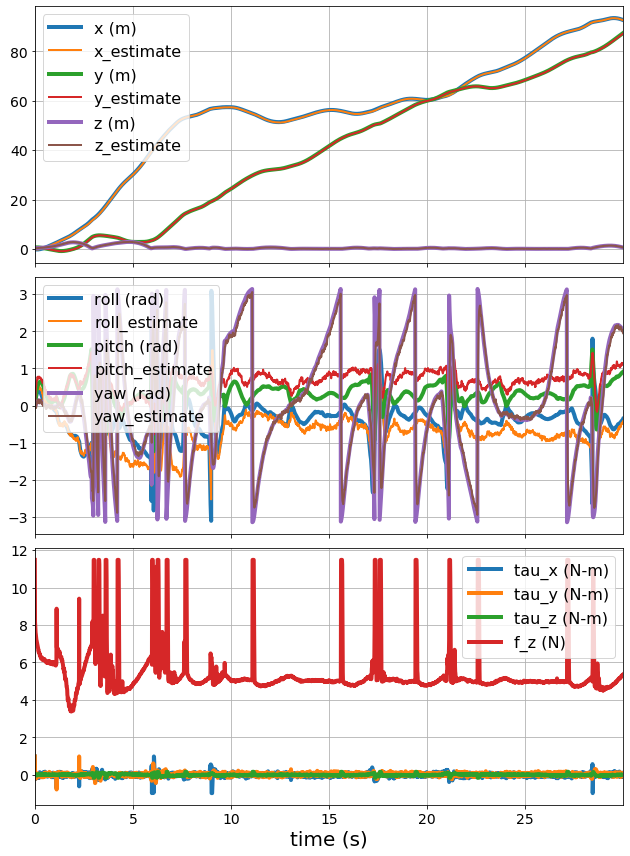

In [33]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_rpy, ax_act) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['pos'][0, :], label='x (m)', linewidth=4)
ax_pos.plot(data['t'],data['xhat'][0,:],label='x_estimate',linewidth=2)
ax_pos.plot(data['t'], data['pos'][1, :], label='y (m)', linewidth=4)
ax_pos.plot(data['t'],data['xhat'][1,:],label='y_estimate',linewidth=2)
ax_pos.plot(data['t'], data['pos'][2, :], label='z (m)', linewidth=4)
ax_pos.plot(data['t'],data['xhat'][2,:],label='z_estimate',linewidth=2)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Roll, pitch, and yaw angles
ax_rpy.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['xhat'][3, :], label='roll_estimate', linewidth=2)
ax_rpy.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['xhat'][4, :], label='pitch_estimate', linewidth=2)
ax_rpy.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['xhat'][5, :], label='yaw_estimate', linewidth=2)
ax_rpy.grid()
ax_rpy.legend(fontsize=16)
ax_rpy.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'].flatten(), label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'].flatten(), label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'].flatten(), label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'].flatten(), label='f_z (N)', linewidth=4)
ax_act.grid()
ax_act.legend(fontsize=16)
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

## Run simulation 20 times

In [25]:
simulator.disconnect()

In [31]:
simulator = ae353_drone.Simulator(display=False)

In [32]:
#note: this part references `raa5`
simulator.clear_drones()
simulator.add_drone(RobotController_V3, 'jushanc2', None)
finish_times = []
trials = 20

failure = 0
success = 0


for i in  range(trials):
    simulator.reset()
    simulator.move_rings()
    simulator.run(max_time=30.)
    
    drone = simulator.get_drone_by_name('jushanc2')
    
    if drone['finish_time'] is None:
        if drone['running']:
            failure += 1
            
    else:
        success += 1
        finish_times.append(drone['finish_time'])
        
    data = drone['data'].copy()
    
    for key in data.keys():
        data[key] = np.array(data[key]).T
    if (i+1)%10 == 0:
        print(i+1, "trials finished")
    
print('Fails= ', failure)
print('Success= ', success)
print('Faliure rate= ', failure/trials)
        

10 trials finished
20 trials finished
Fails=  20
Success=  0
Faliure rate=  1.0


This indicates that the drone has never succeeded in flying through all the rings. Due to time constriant, I declare I have failed in accomplishing the requirement for the drone to fly through all the rings.